In [1]:
import json
import networkx as nx
import requests
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from community import community_louvain

### 1. get the data from json file (node & edges) and bulid the basic network


In [2]:

nodes_edges_json_file = './data/nodes_egdes_new.json'
with open(nodes_edges_json_file,'r') as f:
    node_edges = json.load(f)

# bulid the network from data 
G = nx.DiGraph()

# add nodes    
G.add_nodes_from(node_edges.keys())

# add links
for each in node_edges:
    for link in node_edges[each]:
        G.add_edge(each,link)

print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

number of nodes in network:4215
number of links in network:24614


### 2. define the attributes we want
#### (a) house  
Follow this link, get the attribute of the nodes. Link:
https://harrypotter.fandom.com/wiki/Category:Individuals_by_Hogwarts_house  
Notice that there will be lots of nodes without the house information(not in the list above)
#### (b) muggle or wizard
List for muggles: https://harrypotter.fandom.com/wiki/Category:Muggles  
Also the blood information: https://harrypotter.fandom.com/wiki/Category:Individuals_by_parentage(might be explored if we have spare time)  
*it is interesting that Harry Potter is half-blood.*
#### (c) good or evil (and maybe netural)
No specific one but might get an insight from: https://harrypotter.fandom.com/wiki/Category:Individuals_by_allegiance


### 3. get the attributes with character name by the link and add the attribues to the network
#### (a) house

In [3]:
baseurl = "https://harrypotter.fandom.com/api/v1/Articles/List?"
expand = "expand=1"
namespaces = "namespaces=0"
limit = "limit={}".format(1000)



house_cate_url = 'https://harrypotter.fandom.com/api/v1/Articles/List?expand=1&category=Individuals_by_Hogwarts_house&namespaces=0&limit=100'
r = requests.get(house_cate_url)
response = r.json()

a = 0
house_list = {}
for item in response['items']:
    a += 1
    print("{}\t{}\t({})".format(str(a),item['title'].encode(encoding='utf-8'),item['id']))
    house_name = str(item['title'].encode(encoding='utf-8'))[2:-1]
#     sub_cat.append(title[2:-1])
    house_list[house_name] = []
    
    # for each house 
    category = "category={}".format(house_name)
    query = "{}{}&{}&{}&{}".format(baseurl, expand, category, namespaces, limit)
    r = requests.get(query)
    response = r.json()
    

    for item in response['items']:
        cha_name = str(item['title'].encode(encoding='utf-8'))[2:-1]
        house_list[house_name].append(cha_name)


1	b'Gryffindors'	(76)
2	b'Hufflepuffs'	(329)
3	b'Ravenclaws'	(75)
4	b'Slytherins'	(292)
5	b'Unknown House'	(209171)


In [4]:
# basic statstic of each house
for each_house in house_list:
    print('{} has {} characters'.format(each_house,len(house_list[each_house])))

Gryffindors has 262 characters
Hufflepuffs has 169 characters
Ravenclaws has 165 characters
Slytherins has 223 characters
Unknown House has 164 characters


In [5]:
# get the attribute dist for adding the attibute information into the Graph
house_attr = {}
Hogwarts_cha_list = [] # for collecting characters who once went to Hogwarts
for node_name in G.nodes():
    name_clean = node_name.replace('_',' ')
    house_type = 'Unknown'
    if name_clean in house_list['Gryffindors']:
        house_type = 'Gryffindors'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Hufflepuffs']:
        house_type = 'Hufflepuffs'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Ravenclaws']:
        house_type = 'Ravenclaws'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Slytherins']:
        house_type = 'Slytherins'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Unknown House']:  
        house_type = 'Unknown'
        Hogwarts_cha_list.append(node_name)
    else:
        house_type = 'Unknown'
    
    house_attr[node_name] = house_type
    
# add the attribute to the network
nx.set_node_attributes(G,house_attr,'house_type')

### 4. get the sub-network of Hogwarts

Notice that the rest of characters are not very important if we wanna explore the Hogwarts Houses.

In [6]:
# subgraph
G_Hogwarts = G.subgraph(Hogwarts_cha_list)
# basic stat
print('number of nodes in Hogwarts network:{}'.format(len(G_Hogwarts.nodes())))
print('number of links in Hogwarts network:{}'.format(len(G_Hogwarts.edges())))

number of nodes in Hogwarts network:973
number of links in Hogwarts network:5213


In [33]:
# # to undirected
# G_Hogwarts_undirect = G_Hogwarts.to_undirected()

# # get th GCC of this subgraph
# Gcc = sorted(nx.connected_components(G_Hogwarts_undirect), key=len, reverse=True)
# G_Hogwarts_undirect = G_Hogwarts_undirect.subgraph(Gcc[0])
# print('The biggest GCC of the original network:')
# print('number of nodes in Hogwarts network:{}'.format(len(G_Hogwarts_undirect.nodes())))
# print('number of links in Hogwarts network:{}'.format(len(G_Hogwarts_undirect.edges())))

The biggest GCC of the original network:
number of nodes in Hogwarts network:576
number of links in Hogwarts network:3762


In [7]:
# get the weakly conneted component
largest_cc = max(nx.weakly_connected_components(G_Hogwarts), key=len)
G_Hogwarts = G_Hogwarts.subgraph(largest_cc)
print('The biggest weakly connected component of the original network:')
print('number of nodes in Hogwarts network:{}'.format(len(G_Hogwarts.nodes())))
print('number of links in Hogwarts network:{}'.format(len(G_Hogwarts.edges())))

G_Hogwarts_undirect = G_Hogwarts.to_undirected()

The biggest weakly connected component of the original network:
number of nodes in Hogwarts network:576
number of links in Hogwarts network:5167


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.42it/s]


BarnesHut Approximation  took  1.74  seconds
Repulsion forces  took  13.60  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.23  seconds


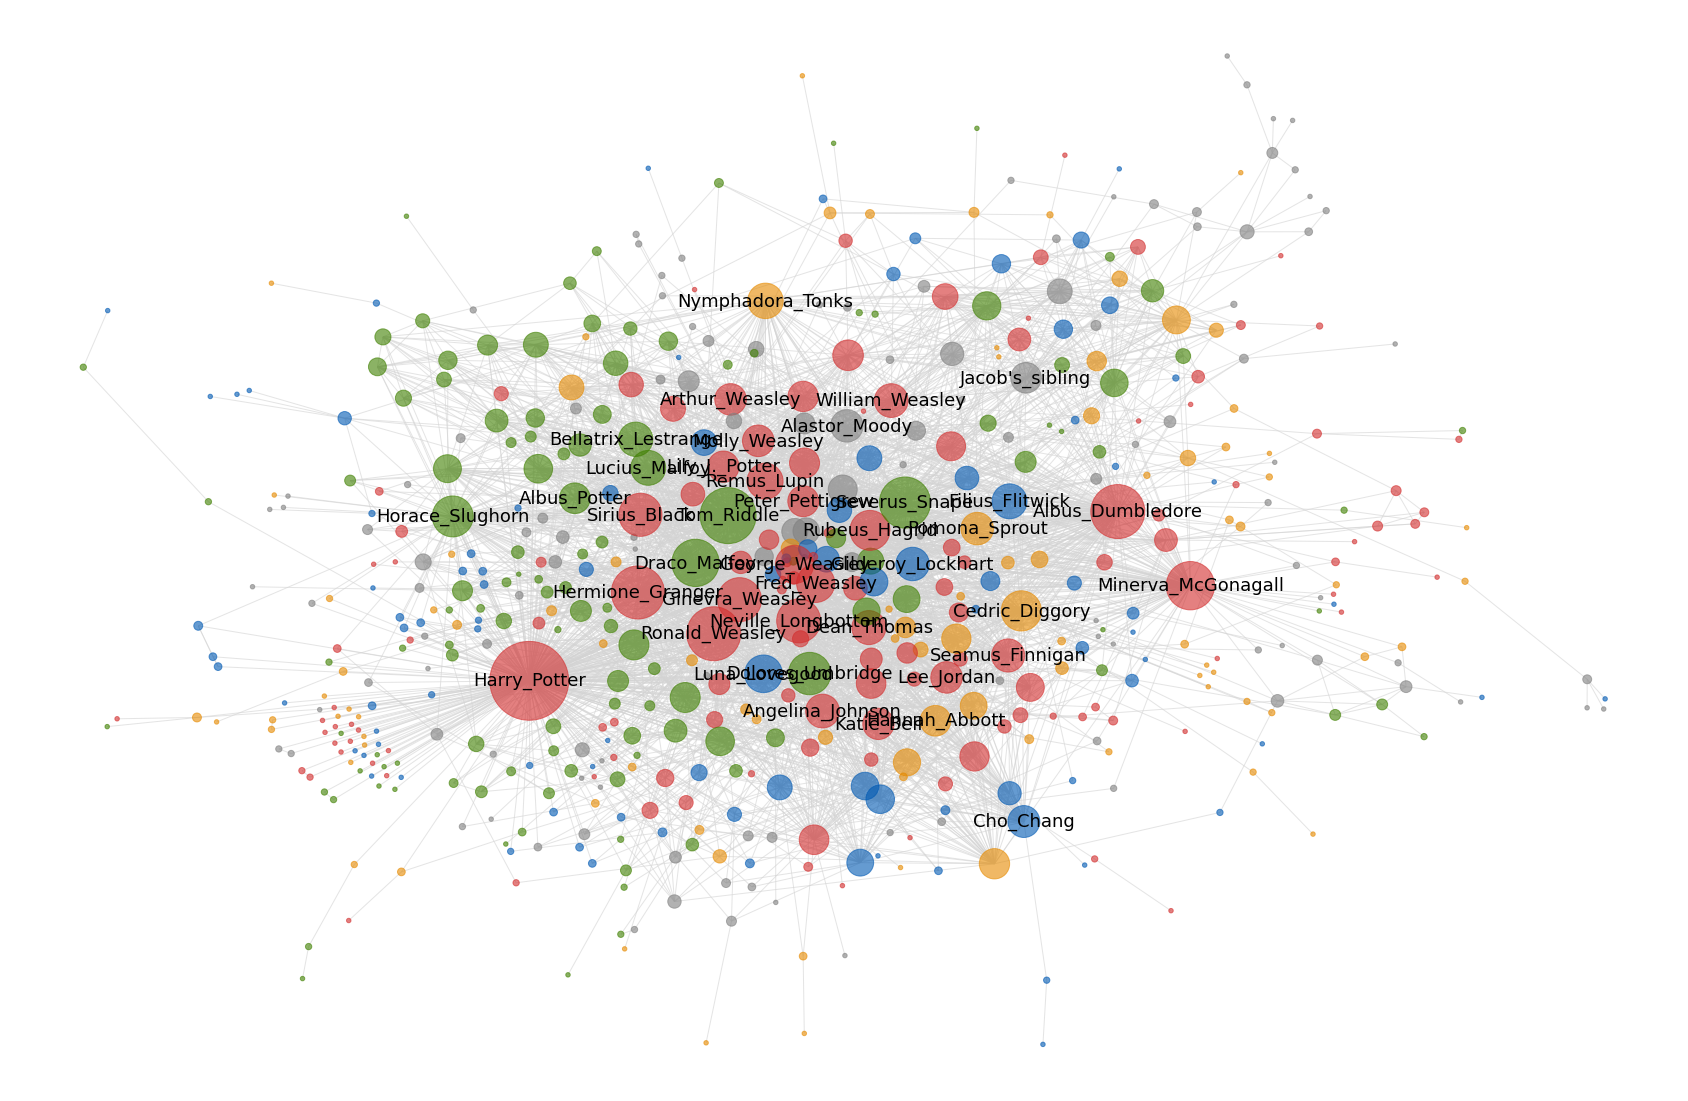

In [39]:
# visualization


# get the dict of degree in G undirected 
d = dict(G_Hogwarts_undirect.degree)

# get the top 20 degree character
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted.keys())[0:40]

# represent for Gryffindors, Hufflepuffs, Ravenclaws and Slytherins respectively (and also unknow ones)
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#808080']

# color map for nodes
color_map_nodes = []
for node in list(G_Hogwarts_undirect.nodes()):
    if nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Gryffindors':
        color_map_nodes.append(colors[0])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Hufflepuffs':
        color_map_nodes.append(colors[1])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Ravenclaws':
        color_map_nodes.append(colors[2])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Slytherins':
        color_map_nodes.append(colors[3])
    else:
        color_map_nodes.append(colors[4])
    
plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=1.2, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_Hogwarts_undirect, pos=None, iterations=1000)
nx.draw_networkx(G_Hogwarts_undirect, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_undirect,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()


### 5. community detection

In [41]:
partition = community_louvain.best_partition(G_Hogwarts_undirect,random_state=0)

In [42]:
par_class = set(partition.values())
par_class_dict = {}
for v in partition.values():
    str_v = str(v)
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [43]:
par_sorted = sorted(par_class_dict.items(),key= lambda item:item[1],reverse = True)
print(par_sorted[:10])
selected_par = list(dict(par_sorted).keys())[:5]
print(selected_par)

[('3', 124), ('4', 118), ('0', 92), ('5', 79), ('6', 58), ('7', 41), ('2', 32), ('8', 27), ('1', 5)]
['3', '4', '0', '5', '6']


In [44]:
community = {}
for par in selected_par:
    com_name = 'com_'+str(par)
    community[com_name] = []
community['other'] = []

for node in G_Hogwarts_undirect.nodes():
    if str(partition[node]) in selected_par:
        com_name = 'com_'+str(partition[node])
        community[com_name].append(node)
    else:
        community['other'].append(node)

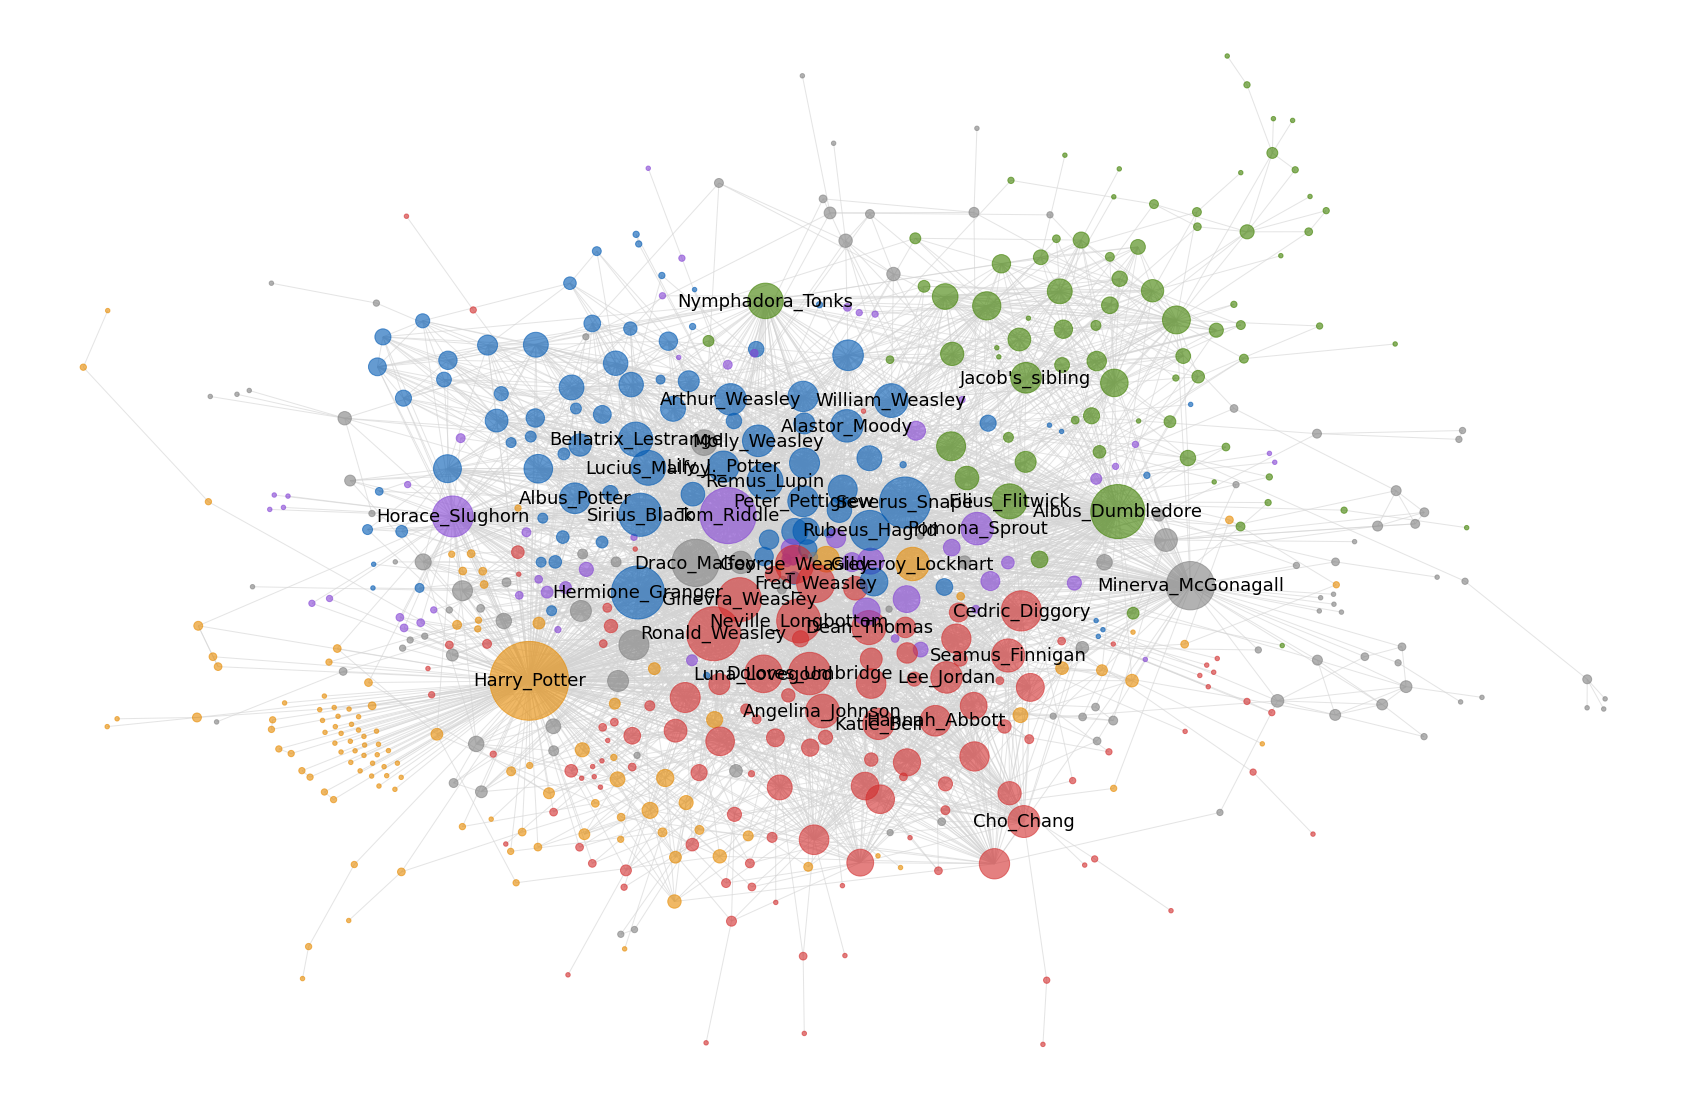

In [45]:
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#8443D5','#808080'] # 5 main community + other

# create a dict for each community
color_dict = {}
for i,par in enumerate(selected_par):
    color_dict[par] = colors[i]
color_dict['other'] = colors[-1]

# color map for nodes
color_map_nodes_2 = []
for node in list(G_Hogwarts_undirect.nodes()):
    if str(partition[node]) in selected_par:
        color = color_dict[str(partition[node])]
    else:
        color = color_dict['other'] 
    color_map_nodes_2.append(color)

plt.figure(figsize=(30,20))
nx.draw_networkx(G_Hogwarts_undirect, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_undirect,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()

### Try with infomap

In [65]:
!pip3 install infomap

You are using pip version 19.0.3, however version 20.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [89]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import infomap
import numpy as np
from matplotlib import cm
%matplotlib inline

In [90]:
# map the node from text to int
def graph_map2int(G):
    ints = np.arange(0,len(G.nodes()))
    mapping = {}
    for i,node_name in enumerate(G.nodes()):
        mapping[node_name] = i

    inv_mapping = {v: k for k, v in mapping.items()}

    G_ints = nx.relabel_nodes(G,mapping)
    return mapping,inv_mapping,G_ints
    
mapping,inv_mapping,G_ints = graph_map2int(G_Hogwarts_undirect)

In [91]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    im = infomap.Infomap()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        im.addLink(*e)

    print("Find communities with Infomap...")
    im.run()

    print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")
    
    partition = {}
    for node in im.tree:
        if node.is_leaf:
            partition[node.node_id] = node.module_id
    
    return partition


partition = findCommunities(G_ints)

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 50 modules with codelength: 7.513050023373495


In [92]:
# convert the partition
def retrive_partition(partition,inv_mapping):
    partition_ori = {}
    for int_id in partition.keys():
        partition_ori[inv_mapping[int_id]]=partition[int_id]
    print(len(partition_ori))
    return partition_ori

partition = retrive_partition(partition,inv_mapping)

576


得到partition之后就是copy paste了。

In [119]:
# define a funtion to get the variable we want for visualization
def community_related_variable(partition,k=5):

    par_class = set(partition.values())
    par_class_dict = {}
    for v in partition.values():
        str_v = str(v)
        if str_v not in par_class_dict.keys():
            par_class_dict[str_v] = 1
        else:
            par_class_dict[str_v] += 1
        
    par_sorted = sorted(par_class_dict.items(),key= lambda item:item[1],reverse = True)
    print(par_sorted[:20])
    selected_par = list(dict(par_sorted).keys())[:k]
    print(selected_par)

#     community = {}
#     for par in selected_par:
#         com_name = 'com_'+str(par)
#         community[com_name] = []
#     community['other'] = []

#     for node in G_Hogwarts_undirect.nodes():
#         if str(partition[node]) in selected_par:
#             com_name = 'com_'+str(partition[node])
#             community[com_name].append(node)
#         else:
#             community['other'].append(node)
    
    return par_class_dict,selected_par
    
par_class_dict,selected_par = community_related_variable(partition)

[('1', 345), ('2', 46), ('3', 13), ('7', 13), ('4', 10), ('5', 10), ('10', 10), ('6', 8), ('8', 7), ('9', 6), ('11', 6), ('13', 5), ('14', 5), ('19', 5), ('12', 4), ('15', 4), ('20', 4), ('16', 3), ('17', 3), ('18', 3)]
['1', '2', '3', '7', '4']


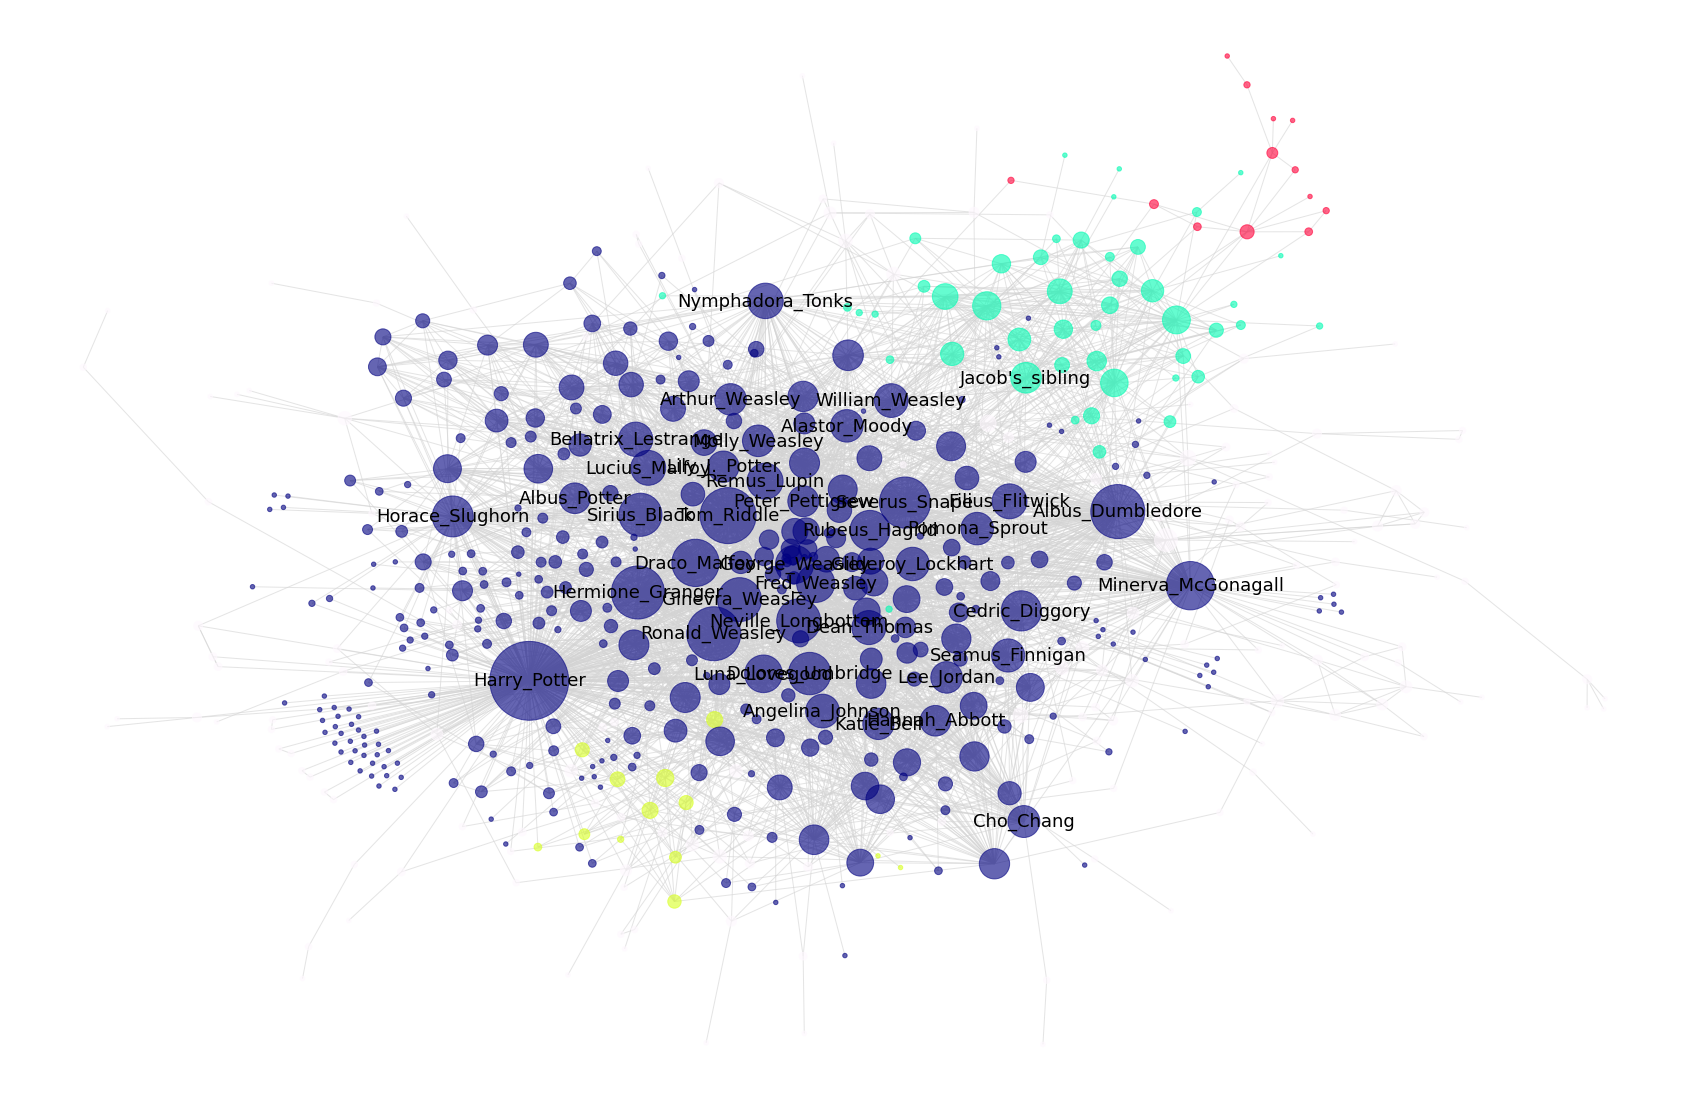

In [97]:
# visualization

def vis(G,positions,partition,selected_par):
    
    gist_ncar = cm.get_cmap('gist_ncar', len(selected_par))
    colors =  gist_ncar(np.linspace(0, 1, len(selected_par)))
#     colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#8443D5','#808080'] # 5 main community + other

    # create a dict for each community
    color_dict = {}
    for i,par in enumerate(selected_par):
        color_dict[par] = colors[i]
    color_dict['other'] = colors[-1]

    # color map for nodes
    color_map_nodes_2 = []
    for node in list(G.nodes()):
        if str(partition[node]) in selected_par:
            color = color_dict[str(partition[node])]
        else:
            color = color_dict['other'] 
        color_map_nodes_2.append(color)

    plt.figure(figsize=(30,20))
    nx.draw_networkx(G, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                        edge_color ='lightgrey',with_labels=False)
    labels = {}
    top_20_cha = list(d_sorted.keys())[0:40]
    for node in top_20_cha:
        labels[node] = node
    nx.draw_networkx_labels(G,positions,labels,font_size=18,font_color='k')
    plt.axis('off')
    plt.show()
    
vis(G_Hogwarts_undirect,positions,partition,selected_par)

思路 顺着大社区再拆分
此处：因为based on modularity的社区检测算法的局限之一是，倾向于生成更大的社区，即使两个小社区并不相似，也可能因为modularity的性质以及贪婪算法被合并。因此此处我们希望可以细分上图最大的社区1. （我没有检验，但是黄色的社区应该是哈利波特游戏中出的角色！特么哈利波特还有游戏）

In [84]:
sub_comminoty_1 = []
for node in partition.keys():
    if partition[node] == 1:
        sub_comminoty_1.append(node)
print('number of the community 1: {}'.format(len(sub_comminoty_1)))

number of the community 1: 345


In [103]:
G_com1 = G_Hogwarts_undirect.subgraph(sub_comminoty_1)
mapping_com1,inv_mapping_com1,G_ints_com1 = graph_map2int(G_com1)
partition_com1 = findCommunities(G_ints_com1)
partition_com1 = retrive_partition(partition_com1,inv_mapping_com1)

partition_com1 = community_louvain.best_partition(G_com1)
par_class_dict_com1,selected_par_com1 = community_related_variable(partition_com1)

par_sorted_com1 = sorted(par_class_dict_com1.items(),key= lambda item:item[1],reverse = True)
selected_par_com1 = list(dict(par_sorted_com1).keys())
print(selected_par_com1)

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 1 modules with codelength: 7.259746792954456
345
[('3', 82), ('1', 70), ('6', 58), ('4', 48), ('2', 38), ('0', 27), ('5', 22)]
['3', '1', '6', '4', '2']
['3', '1', '6', '4', '2', '0', '5']


In [98]:
print(par_class_dict)

{'1': 345, '2': 46, '3': 13, '4': 10, '5': 10, '6': 8, '7': 13, '8': 7, '9': 6, '10': 10, '11': 6, '12': 4, '13': 5, '14': 5, '15': 4, '16': 3, '17': 3, '18': 3, '19': 5, '20': 4, '21': 3, '22': 3, '23': 3, '24': 3, '25': 2, '26': 2, '27': 2, '28': 2, '29': 2, '30': 2, '31': 3, '32': 3, '33': 2, '34': 2, '35': 2, '36': 2, '37': 2, '38': 2, '39': 2, '40': 2, '41': 2, '42': 2, '43': 2, '44': 2, '45': 2, '46': 2, '47': 2, '48': 2, '49': 2, '50': 2}


In [113]:
# replace the 'com1' into these sub_partitions
new_partition = {}
for node in partition.keys():
    if str(partition[node]) in selected_par:
        if partition[node] == 1:
            new_partition[node] = partition_com1[node]+100
        else:
            new_partition[node] = partition[node]
    else: # others
        new_partition[node] = 1024
        
selected_par_com1 = list(set(new_partition.values()))
selected_par_com1 =[str(k) for k in selected_par_com1]
selected_par_com1

['1024', '2', '3', '100', '101', '102', '103', '104', '105', '106', '4', '7']

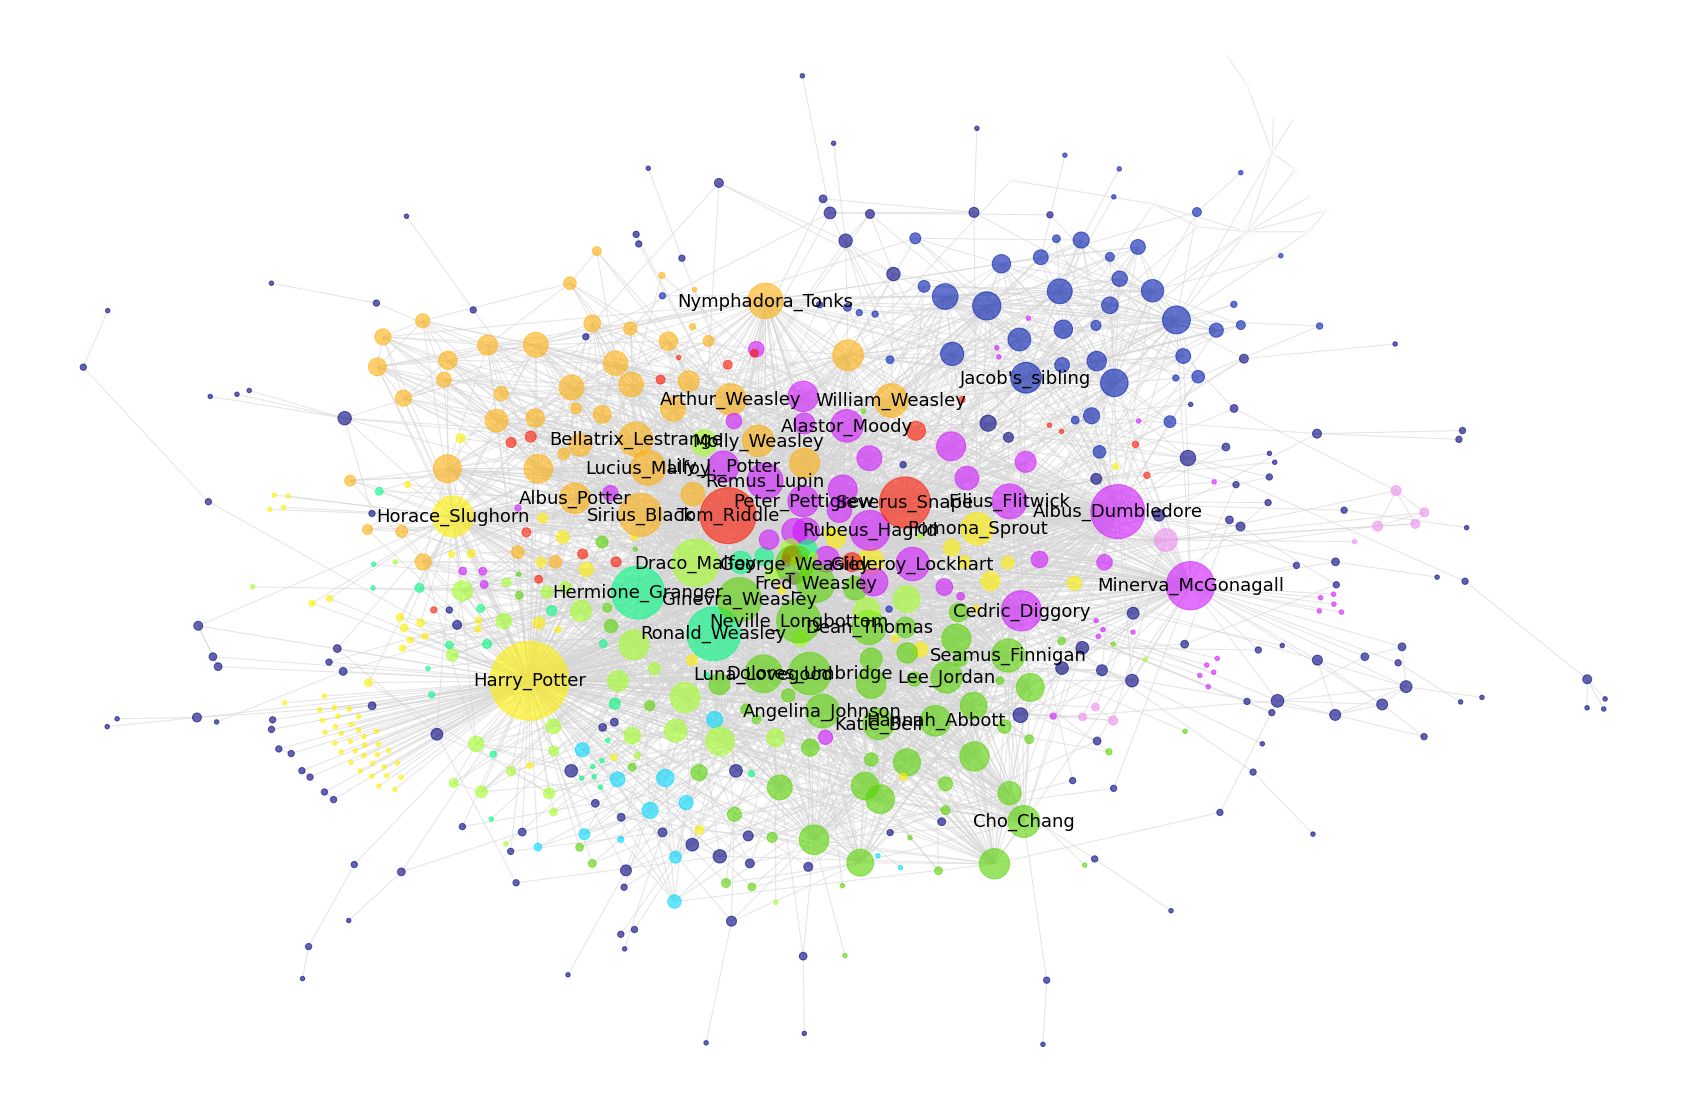

In [115]:
vis(G_Hogwarts_undirect,positions,new_partition,selected_par_com1)

好奇部分：如果给全图划区+可视化？

In [121]:
G_undirected = G.to_undirected()
partition_G = community_louvain.best_partition(G_undirected)
par_class_dict_G,selected_par_G = community_related_variable(partition_G,k=10)

[('1', 518), ('2', 500), ('7', 484), ('9', 328), ('19', 247), ('11', 226), ('20', 193), ('6', 191), ('17', 178), ('18', 134), ('31', 123), ('16', 94), ('10', 87), ('0', 60), ('81', 28), ('257', 7), ('74', 6), ('108', 6), ('510', 6), ('225', 4)]
['1', '2', '7', '9', '19', '11', '20', '6', '17', '18']


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.57it/s]


BarnesHut Approximation  took  5.69  seconds
Repulsion forces  took  70.60  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.52  seconds


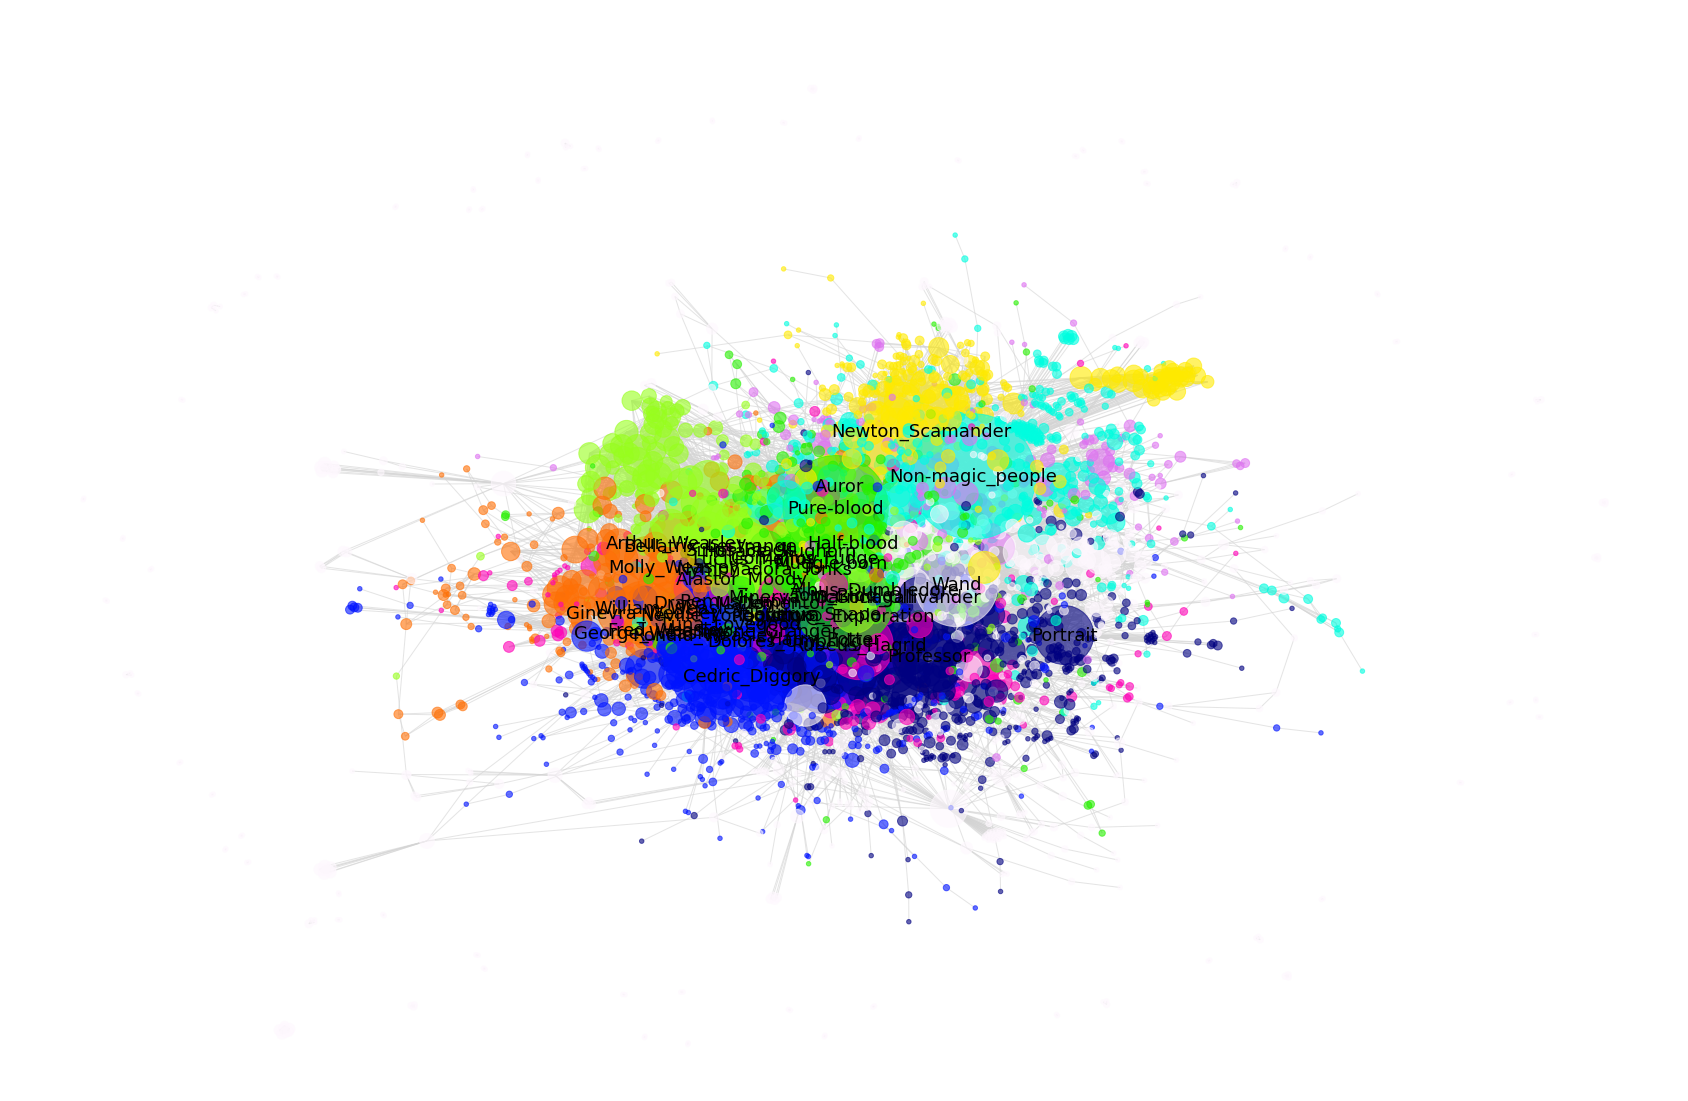

In [132]:
# visualization


# get the dict of degree in G undirected 
d_all = dict(G_undirected.degree)

# get the top 20 degree character
d_sorted_all = dict(sorted(d_all.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted_all.keys())[0:40]

# represent for Gryffindors, Hufflepuffs, Ravenclaws and Slytherins respectively (and also unknow ones)
gist_ncar = cm.get_cmap('gist_ncar', len(selected_par_G))
colors =  gist_ncar(np.linspace(0, 1, len(selected_par_G)))

# create a dict for each community
color_dict = {}
for i,par in enumerate(selected_par_G):
    color_dict[par] = colors[i]
color_dict['other'] = colors[-1]

# color map for nodes
color_map_nodes_2 = []
for node in list(G.nodes()):
    if str(partition_G[node]) in selected_par_G:
        color = color_dict[str(partition_G[node])]
    else:
        color = color_dict['other'] 
    color_map_nodes_2.append(color)
    
plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=1, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions_all = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=200)
nx.draw_networkx(G_undirected, positions_all,nodelist=d_all.keys(), node_size=[v * 20 for v in d_all.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_undirected,positions_all,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()


1. 可以看到 还是需要手动筛掉一些结点（non-magican people ; pure blood；wand之类的 ）
2. 如何调整可视化结果：forceatlas2大括号中的参数scalingRatio，gravity；iterations一定程度上也有帮助。
